In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sigma = 0.3
def func(x):
    return np.sin(2 * np.pi * x)

def generate_data(N, sigma=0.3, seed=None):
    rng = np.random.default_rng(seed)
    x = rng.uniform(0.0, 1.0, size=N)
    t = func(x) + rng.normal(0.0, sigma, size=N)
    return x, t

In [12]:
# -----------------------------
# Design matrix and fitting
# -----------------------------
def design_matrix(x, M):
    """
    Build design matrix Phi with columns [x^0, x^1, ..., x^M].
    Shape: (N, M+1)
    """
    return np.vander(x, N=M+1, increasing=True)

def fit_poly_ridge(x, t, M, lam=0.0):
    """
    Ridge regression solution:
    w = (Phi^T Phi + lam I)^(-1) Phi^T t
    lam = 0 gives ordinary least squares.
    """
    Phi = design_matrix(x, M)
   
    I = np.eye(M + 1) # Identity matrix
    w = np.linalg.solve(Phi.T @ Phi + lam * I, Phi.T @ t)
    return w

def predict(x, w):
    M = len(w) - 1
    Phi = design_matrix(x, M)
    return Phi @ w

def erms(y, t):
    return np.sqrt(np.mean((y - t) ** 2))

In [13]:
# -----------------------------
# 3. Simple visualization: different M, N=10 / 100 / 1000
# -----------------------------

def plot_fits_for_sample_sizes():
    Ns = [10, 100, 1000]
    M_max = 9

    x_plot = np.linspace(0, 1, 1000)
    y_true = func(x_plot)

    for N in Ns:
        x, t = generate_data(N, sigma=sigma, seed=0)

        plt.figure(figsize=(6, 4))
        plt.scatter(x, t, alpha=0.3, c="black", label="data")
        plt.plot(x_plot, y_true, label=r"sin(2 $\pi$ x)")

        for M in [0, 1, 3, 9]:
            w = fit_poly_ridge(x, t, M, lam=0.0)
            y_fit = predict(x_plot, w)
            plt.plot(x_plot, y_fit, label=f"N={M}")

        plt.title(f"Polynomial fits, N={N}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
    plt.show()

In [14]:
def train_test_errors_regularization(log_lam=None):
    """
    If log_lam is None -> no regularization.
    Otherwise lambda = exp(log_lam).
    """
    N = 100
    x_all, t_all = generate_data(N, sigma=sigma, seed=1)

    rng = np.random.default_rng(1)
    idx = rng.permutation(N)
    N_train = int(0.25 * N)
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    x_train, t_train = x_all[train_idx], t_all[train_idx]
    x_test, t_test = x_all[test_idx], t_all[test_idx]

    M_max = 9
    Ms = np.arange(0, M_max + 1)
    Erms_train = []
    Erms_test = []

    if log_lam is None:
        lam = 0.0
        label_suffix = "(no regularization)"
    else:
        lam = np.exp(log_lam)
        label_suffix = f"(ln λ = {log_lam})"

    for M in Ms:
        w = fit_poly_ridge(x_train, t_train, M, lam=lam)
        y_train = predict(x_train, w)
        y_test = predict(x_test, w)
        Erms_train.append(erms(y_train, t_train))
        Erms_test.append(erms(y_test, t_test))

    plt.figure(figsize=(6, 4))
    plt.plot(Ms, Erms_train, "o-", label="training")
    plt.plot(Ms, Erms_test, "s-", label="test")
    plt.axhline(sigma, linestyle="--", label=r"noise $\sigma$")
    plt.xlabel("Polynomial degree M")
    plt.ylabel(r"$E_{\mathrm{RMS}}$")
    plt.title(f"$E_{{RMS}}$ vs M {label_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def bayesian_posterior_params(x_train, t_train, M, alpha, beta):
  """
  Returns posterior covariance S and posterior mean m_N (for weights w):
    S^{-1} = alpha I + beta Phi^T Phi
    m_N    = beta S Phi^T t
  """
  Phi = design_matrix(x_train, M)
  I = np.eye(M + 1)

  S_inv = alpha * I + beta * (Phi.T @ Phi)
  S = np.linalg.inv(S_inv)
  mN = beta * (S @ Phi.T @ t_train)

  return S, mN

def bayesian_predictive(x_test, S, mN, M, beta):
  """
  Predictive distribution p(t|x, D) = N(t | m(x), s^2(x))
    m(x)  = phi(x)^T mN
    s^2(x)= beta^{-1} + phi(x)^T S phi(x)
  """
  Phi_test = design_matrix(x_test, M)

  mean = Phi_test @ mN
  var = (1.0 / beta) + np.sum((Phi_test @ S) * Phi_test, axis=1)

  return mean, var

def plot_bayesian_curve_fit(N=10, sigma=0.3, seed=0, M=9, alpha=5e-3, beta=11.1):
  # training data
  x_train, t_train = generate_data(N, sigma=sigma, seed=seed)

  # posterior over weights
  S, mN = bayesian_posterior_params(x_train, t_train, M, alpha, beta)

  # prediction grid
  x_plot = np.linspace(0, 1, 400)
  y_true = func(x_plot)

  # predictive mean/variance
  mean, var = bayesian_predictive(x_plot, S, mN, M, beta)
  std = np.sqrt(var)

  # plot
  plt.figure(figsize=(6,4))
  plt.scatter(x_train, t_train, alpha=0.5, c="black", label="data")
  plt.plot(x_plot, y_true, "C0", lw=2, label=r"$\sin(2\pi x)$")
  plt.plot(x_plot, mean, "C1", lw=2, label="predictive mean")

  plt.fill_between(x_plot, mean - std, mean + std, alpha=0.2, label=r"$\pm 1\sigma$ band")

  plt.title(f"Bayesian curve fitting (M={M}, alpha={alpha}, beta={beta}, N={N})")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.grid(True, alpha=0.3)
  plt.legend()
  plt.show()

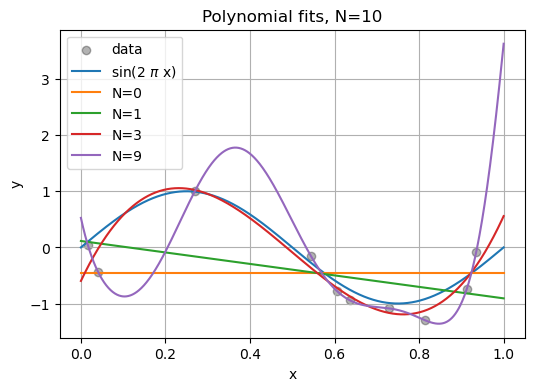

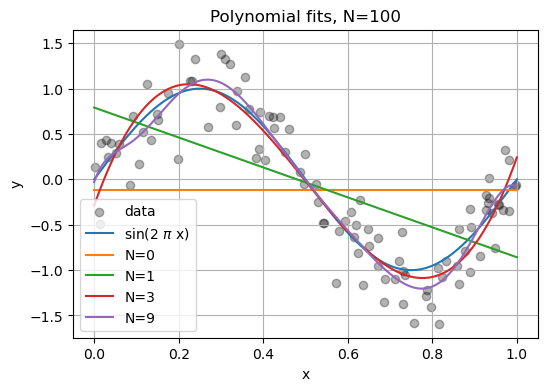

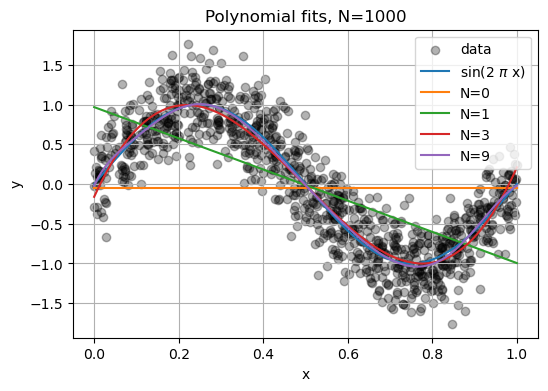

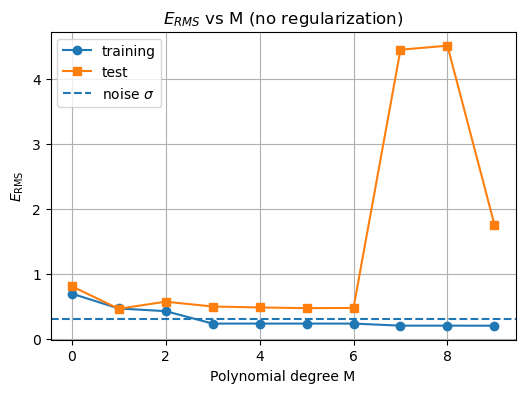

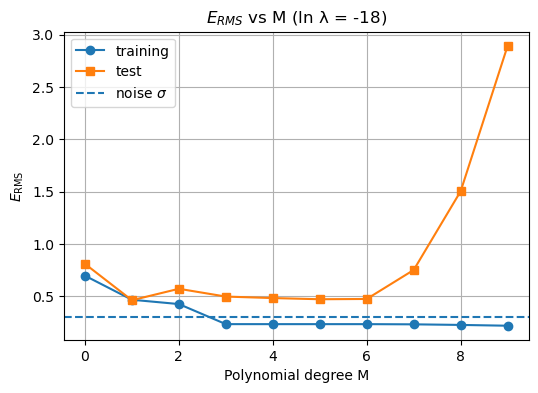

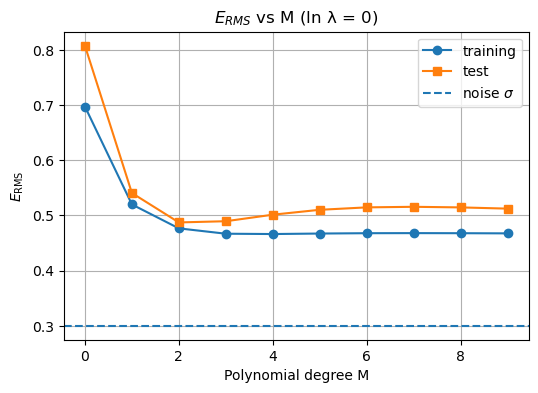

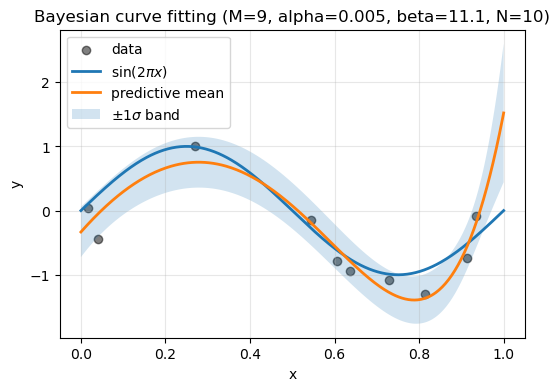

In [16]:
if __name__ == "__main__":
    # Activity 1 style plots
    plot_fits_for_sample_sizes()

    # ERMS vs M without regularization
    train_test_errors_regularization(log_lam=None)

    # Activity 2: regularization
    # ln λ = -18 (very small regularization)
    train_test_errors_regularization(log_lam=-18)

    # ln λ = 0 (λ = 1, stronger regularization)
    train_test_errors_regularization(log_lam=0)

    # Activity 4: Bayesian curve fitting
    plot_bayesian_curve_fit(N=10, sigma=0.3, seed=0, M=9, alpha=5e-3, beta=11.1)

# PHY657 — Module 1 (Spring 2026)
## Notebook write-up (Markdown + LaTeX)

---

## Activity 1: Simple regression problem (frequentist approach)

### Data generation + plots (intro)
We generate a training data set from the target function
$\;y(x) = \sin(2\pi x)\;$ with additive Gaussian noise of standard deviation $\sigma = 0.3$.
The input $x$ values are drawn uniformly from $[0,1]$. Plotting $y$ versus $x$ for different
sample sizes (e.g. $N=10,100,1000$) illustrates how increasing $N$ makes the underlying
sinusoidal trend easier to identify despite noise.

### (a) Outcome vs polynomial order and number of data points
As the polynomial order increases, the model becomes more flexible and the training fit improves.
Low-order polynomials underfit and fail to capture the oscillatory structure, while high-order
polynomials can overfit and exhibit large oscillations between points. Increasing the number of
data points reduces overfitting because the data constrain the model more strongly, so higher-order
fits generalize better when $N$ is large.

### (b) Noise vs $E_{\mathrm{RMS}}$ for $M=9$ and $N=100$
For a 9th-order polynomial fitted to $N=100$, the RMS error $E_{\mathrm{RMS}}$ is expected to be
of order the noise level $\sigma=0.3$. If $E_{\mathrm{RMS}}\approx \sigma$, the model is capturing
the underlying signal without strongly fitting noise; if $E_{\mathrm{RMS}}\ll \sigma$, that suggests
overfitting; if $E_{\mathrm{RMS}}\gg \sigma$, that suggests mismatch/underfitting or poor conditioning.

### (c) Training vs test error (25% train / 75% test) as a function of $M$
The training RMS error typically decreases monotonically with increasing polynomial order $M$,
since additional parameters allow the model to fit the training data more closely. The test error
usually decreases at first (reduced bias), reaches a minimum at an intermediate $M$, and then
increases (higher variance/overfitting). This behavior illustrates the bias–variance tradeoff:
too-simple models underfit, while overly flexible models fit noise and generalize poorly.

---

## Activity 2: Linear regression with regularization

### Regularized objective
We introduce weight decay regularization by minimizing a penalized sum-of-squares error of the form
$$
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^{N}\left(y(x_n,\mathbf{w})-t_n\right)^2
+ \frac{\lambda}{2}\,\|\mathbf{w}\|^2,
$$
as in Eq. 1.4. We compare results for $\ln\lambda=-18$ (very weak regularization) and $\ln\lambda=0$
(stronger regularization), consistent with the comparison shown in Fig. 1.7.

### (a) Why Fig. 1.7 (left) and (right) are so different
Regularization suppresses large weight values that produce strong oscillations in high-order polynomial
fits. For small $\lambda$ the penalty is negligible, so the solution resembles the unregularized fit and
may overfit the noise. For larger $\lambda$ the weights are forced toward smaller magnitudes, producing
a smoother curve that is less sensitive to noise and typically generalizes better.

### (b) Why the outcome is worse for $\lambda\to 0$ or very large $\lambda$ (Fig. 1.8)
When $\lambda\to 0$, the penalty vanishes and the model can overfit the noise, increasing the test error.
When $\lambda$ is very large, the penalty dominates and drives weights toward zero, making the model too rigid
and causing underfitting. Best performance occurs at an intermediate $\lambda$ that balances data fit and model
complexity.

---

## Activity 3: Practice on Bayes theorem (no coding)

Given:
- Prior probability of disease: $P(A)=0.001$
- Test sensitivity: $P(+|A)=0.98$
- False positive rate: $P(+|\neg A)=0.03$

We want the posterior probability $P(A|+)$.

### Posterior probability
Using Bayes’ theorem,
$$
P(A|+) = \frac{P(+|A)P(A)}{P(+)} ,
$$
where the evidence (normalization) is
$$
P(+) = P(+|A)P(A) + P(+|\neg A)P(\neg A).
$$

Substituting values:
$$
P(+) = (0.98)(0.001) + (0.03)(0.999) = 0.00098 + 0.02997 = 0.03095,
$$
so
$$
P(A|+) = \frac{0.98\times 0.001}{0.03095} \approx 0.0317 \;\; \text{about 3.2}.
$$

A positive test result is therefore **not** strong evidence for disease by itself, because the disease is rare
and false positives dominate the positive pool.

### Required identification
- **Likelihood:** $P(+|A)$ and $P(+|\neg A)$
- **Prior:** $P(A)=0.001$, $P(\neg A)=0.999$
- **Normalization (evidence):** $P(+)=P(+|A)P(A)+P(+|\neg A)P(\neg A)$

---

## Activity 4: Bayesian curve fitting (M = 9 polynomial)

We fit the noisy sinusoidal data using a polynomial model with degree $M=9$ and follow the Bayesian linear regression
procedure described in Sec. 1.2.6 (Eqs. 1.68–1.72). The hyperparameters are treated as input values:
$\alpha = 5\times 10^{-3}$ and $\beta = 11.1$. This yields a predictive mean curve and uncertainty bands, as in Fig. 1.17.

### (a) Why $\beta = 11.1$ is expected
In the Bayesian formulation, $\beta$ is the **precision** (inverse variance) of the observational noise:
$$
\beta = \frac{1}{\sigma^2}.
$$
Since the data were generated with Gaussian noise $\sigma=0.3$,
$$
\beta \approx \frac{1}{0.3^2} = \frac{1}{0.09} \approx 11.11,
$$
which is consistent with the input value $\beta = 11.1$. Physically, $\beta$ sets how tightly the data are expected to
cluster around the underlying function.

### (b) Comparison with frequentist fitting
The frequentist approach produces a single best-fit parameter vector (point estimate) and typically selects model complexity
through choices like polynomial degree or regularization strength. In contrast, Bayesian curve fitting treats model parameters
as random variables and combines the likelihood (controlled by $\beta$) with a prior over weights (controlled by $\alpha$).
Predictions are obtained by marginalizing over the posterior, yielding both a predictive mean and principled uncertainty
intervals. This often reduces overfitting and provides a more informative result than a single best-fit curve.

---
